<a href="https://colab.research.google.com/github/Prabhitha/GANs/blob/main/GAN_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN
#### GAN- CIFAR100 dataset using Pytorch

In [2]:
# Importing the dependencies

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Loading the dataset
transform_train = transforms.Compose([
        transforms.ToTensor()
])  

if "data" in os.listdir():
    print("Dataset already exists")
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)
else:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=2)

Dataset already exists


torch.Size([50, 3, 32, 32])


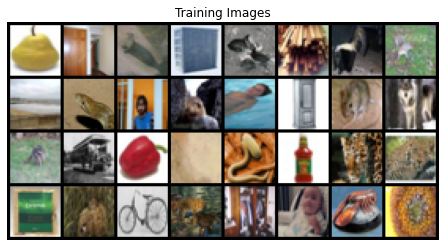

In [5]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(16,4))
plt.axis("off")
plt.title("Training Images")
print((real_batch[0].to(device)).shape)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

## Discriminator Model

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 1, kernel_size = 2, stride = 1, padding = 0, bias = False)
        
    def forward(self, x):
        #x = x.view(-1, 3, 32, 32)
        x = F.leaky_relu(self.conv1(x), 0.2, inplace = True)
        x = self.conv2(x)
        x = F.leaky_relu(self.conv2_bn(x), 0.2, inplace = True)
        x = self.conv3(x)
        x = F.leaky_relu(self.conv3_bn(x), 0.2, inplace = True)
        x = self.conv4(x)
        x = F.leaky_relu(self.conv4_bn(x), 0.2, inplace = True)
        x = self.conv5(x)
        x = F.sigmoid(x)
        out = x.view(-1, 1)
        
        return out        

## Generator Model


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(100, 256, kernel_size = 2, stride = 1, padding = 0, bias = False)
        self.conv_transpose1_bn = nn.BatchNorm2d(256)
        self.conv_transpose2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv_transpose2_bn = nn.BatchNorm2d(128)
        self.conv_transpose3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv_transpose3_bn = nn.BatchNorm2d(64)
        self.conv_transpose4 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 1, bias = False)
        self.conv_transpose4_bn = nn.BatchNorm2d(32)
        self.conv_transpose5 = nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding = 1, bias = False)
    
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        x = self.conv_transpose1(x)
        x = F.relu(self.conv_transpose1_bn(x), inplace = True)
        x = self.conv_transpose2(x)
        x = F.relu(self.conv_transpose2_bn(x), inplace = True)
        x = self.conv_transpose3(x)
        x = F.relu(self.conv_transpose3_bn(x), inplace = True)
        x = self.conv_transpose4(x)
        x = F.relu(self.conv_transpose4_bn(x), inplace = True)
        x = self.conv_transpose5(x)
        out = torch.tanh(x)
        
        return out 

In [8]:
# weights initialization 

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Create the Discriminator
D = Discriminator()
D = D.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
D = D.float()
D.apply(weights_init)

# Print the model
print(D)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
)


In [10]:
# Create the Generator
G = Generator()
G = G.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
G = G.float()
G.apply(weights_init)

# Print the model
print(G)

Generator(
  (conv_transpose1): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (conv_transpose1_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv_transpose2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv_transpose3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose4): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv_transpose4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose5): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
)


In [11]:
loss = nn.BCELoss()
def real_loss_fn(real_out):
    labels = torch.ones(real_out.size()[0], 1).to(device)
    loss_real = loss(real_out.squeeze(), labels.squeeze())
    return loss_real

def fake_loss_fn(fake_out):
    labels = torch.zeros(fake_out.size()[0], 1).to(device)
    loss_fake = loss(fake_out.squeeze(), labels.squeeze())
    return loss_fake

In [12]:
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Learning rate for optimizers
lr = 0.0002

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))


In [13]:
def train(D, G, dataloader, optimizerD, optimizerG, num_epochs, fac, batch_size = 50):
    
    disc_losses = []
    gen_losses = []
    
    fixed_noise = torch.randn(32, 100).to(device)
    
    D.train()
    G.train()
    
    for epoch in range(num_epochs + 1):
        
        gen_loss_total = 0
        disc_loss_total = 0
        
        for i, data in enumerate(dataloader, 0):
            optimizerD.zero_grad()
            
            x = data[0].to(device)
            real_out = D(x.float())
            real_loss = real_loss_fn(real_out)
            
            gen_in1 = torch.randn(batch_size, 100).to(device)
            disc_gen_in1 = G(gen_in1.float()).detach()
            fake_out = D(disc_gen_in1.float())
            fake_loss = fake_loss_fn(fake_out)
            
            disc_loss = real_loss + fake_loss
            disc_loss_total += disc_loss
            
            disc_loss.backward()
            optimizerD.step()
            
            optimizerG.zero_grad()
            
            gen_in2 = torch.randn(batch_size, 100).to(device)
            disc_gen_in2 = G(gen_in2.float())
            real_fake_out = D(disc_gen_in2.float())
            gen_loss = real_loss_fn(real_fake_out)
            gen_loss_total += gen_loss
            
            gen_loss.backward()
            optimizerG.step()
            
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        print("Epoch ", epoch, " - ", "Discriminator Loss: ", disc_loss_total/len(dataloader), " Generator Loss: ", gen_loss_total/len(dataloader))
            
    return disc_losses, gen_losses            

In [14]:
disc_losses, gen_losses = train(D, G, trainloader, optimizerD, optimizerG, 5, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch  0  -  Discriminator Loss:  tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(8.6690, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1  -  Discriminator Loss:  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(11.0776, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2  -  Discriminator Loss:  tensor(4.1242e-05, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(12.0356, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3  -  Discriminator Loss:  tensor(1.9914e-05, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(12.8755, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4  -  Discriminator Loss:  tensor(1.0657e-05, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(13.6471, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5  -  Discriminator Loss:  tensor(5.5908e-06, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(14.1616, device='cuda:0', grad_fn=<DivBackwar